# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 24.11.2021

Мягкий дедлайн: 23:59MSK 04.12.2021

Жесткий дедлайн: 23:59MSK 10.12.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

/Users/katyona/Desktop/University/proga/iad/notebooks/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets i

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

36.68286416852989

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

Для расчета среднего предсказания по одному объекту необходимо иметь сумму предсказаний и их количество на данном объекте.

Для расчета выборочной дисперсии на одном объекте необходимо иметь, как видно по формуле ниже, среднее, сумму предсказаний и сумму квадратов предсказаний, а также их количество.
$$
s^2 = \frac{\sum_{i=1}^n (x_i - \bar x)^2}{n} = \frac{\sum_{i=1}^n (x_i^2  - 2 x_i \bar x + \bar x^2)}{n} = \frac{\sum_{i=1}^n (x_i^2  - 2 x_i \bar x)}{n} + \frac{n\bar x^2}{n} = \frac{\sum_{i=1}^n x_i^2  - 2 \bar x \sum_{i=1}^n x_i  + n\bar x^2}{n}, 
$$ $x_i$ - i-e предсказание на данном объекте, n - количество предсказаний на объекте, $\bar x$ - среднее по предсказаниям на данном объекте

Причем   $$2 \bar x \sum_{i=1}^n x_i = 2 \bar x n \bar x = 2n \bar x^2,$$ откуда получаем:
$$
s^2 = \frac{\sum_{i=1}^n x_i^2 - n\bar x^2}{n} = \frac{\sum_{i=1}^n x_i^2}{n} - \bar x^2
$$

Для расчета средней ошибки на одном объекте, необходимо иметь также сумму предсказаний и их квадратов, а также их количество:
$$
\bar L = \frac{\sum_{i=1}^n (x_i - y)^2}{n} = \frac{\sum_{i=1}^n (x_i^2 - 2x_i y + y^2)}{n} = \frac{\sum_{i=1}^n x_i^2 - 2y\sum_{i=1}^n x_i + ny^2}{n} = \frac{\sum_{i=1}^n x_i^2 - 2yn\bar x + ny^2}{n} = \frac{\sum_{i=1}^n x_i^2}{n} - 2y\bar x + y^2
$$

In [7]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    SUM, SQ, NUM = 0, 1, 2
    l = X.shape[0]
    counter = np.zeros((l, 3))
    indexes = np.arange(0, l)
    for _ in range(num_runs):
        # сгенерировать выборку бутстрапом X_j
        ind_X = np.random.choice(l, l, p = [1 / l] * l)
        # определить T_j - мн-во невошедших в X_j объектов
        ind_T = np.setdiff1d(indexes, ind_X)
        # обучить на ней алгоритм a_j
        regressor.fit(X[ind_X], y[ind_X])
        # добавить предсказание для каждого объекта в T_j
        predicts = regressor.predict(X[ind_T])
        
        counter[ind_T, SUM] += predicts
        counter[ind_T, SQ] += predicts**2
        counter[ind_T, NUM] += 1
    
    # считаем только по тем объектам, которые попали хотя бы в одно T_j
    ind_include = np.where(counter[:, NUM] != 0)
    counter = counter[ind_include]
    y_inc = y[ind_include]
    # среднее предсказание на каждом объекте
    mean = counter[:, SUM] / counter[:, NUM]
    # смещение
    bias = ((mean - y_inc)**2).mean()
    # разброс
    variance = (counter[:, SQ] / counter[:, NUM] - mean**2).mean()
    # средняя ошибка
    L_mean = (counter[:, SQ] / counter[:, NUM] - 2 * y_inc * mean + y_inc**2).mean()
    return (np.round(bias, 5), np.round(variance, 5), np.round(L_mean, 5))

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [9]:
results = pd.DataFrame(np.zeros((4, 6)), 
                       columns=['LR', 'Tree', 'RF', 'BaggingLR', 'BaggingTree', 'BaggingRF'],
                      index=['Bias', 'Variance', 'L_mean', 'Bias + Variance'])

In [10]:
results

,LR,Tree,RF,BaggingLR,BaggingTree,BaggingRF
Bias,0.0,0.0,0.0,0.0,0.0,0.0
Variance,0.0,0.0,0.0,0.0,0.0,0.0
L_mean,0.0,0.0,0.0,0.0,0.0,0.0
Bias + Variance,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
regressors = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
name = ['LR', 'Tree', 'RF']
for i in range(len(regressors)):
    bias, variance, L_mean = compute_biase_variance(regressors[i], X, y)
    print(f'Regressor: {name[i]}', 
          f'Bias: {bias}',
          f'Variance: {variance},',
          f'L_mean: {L_mean}', sep='\n', end='\n\n')
    results[name[i]] = [bias, variance, L_mean, bias + variance]

Regressor: LR
Bias: 23.73857
Variance: 0.95352,
L_mean: 24.69209

Regressor: Tree
Bias: 10.20214
Variance: 12.87796,
L_mean: 23.0801

Regressor: RF
Bias: 10.50669
Variance: 2.22285,
L_mean: 12.72954



__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ Да, согласуется
* Действительно, если считать шум равным нулю, то средняя ошибка равна сумме смещения и разброса. 
* Самое высокое смещение у линейной модели, что логично, тк она не является очень мощной. Зато разброс у нее почти нулевой, тк она особо не переобучается
* У дерева и леса смещение гораздо ниже, чем у линейной модели, так как они гораздо мощнее и точнее предсказывают результат. При этом переобучаются они сильнее, поэтому разброс, показывающий зависимость от обучающей выборки, гораздо выше. 
* У дерева и леса примерно одинаковое смещение, а вот разброс у леса значительно ниже, что тоже логично - за счет того, что каждое дерево в лесу обучается на случайной подвыборке признаков, переобучение у композиции таких деревьев ниже, так как корреляция между ними мала.

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__
* Для линейной регрессии ничего не поменялось, ошибка даже немного выросла за счет роста разброса, так как композиция линейных моделей - это линейная модель. 
* Бэггинг для одиночных деревьев показал результат несколько хуже, чем случайный лес в прошлом эксперименте. Смещение почти не поменялось, зато разброс упал очень сильно. Это свзяано с тем, что композиция деревьев по мощности такая же сильная, как и одно дерево, но при этом она переобучается меньше, чем просто дерево, за счет использования бутстрапа при построении каждого последующего дерева. При этом композиция деревьев имеет разброс выше, чем случайный лес, тк у случайного леса, как уже говорилось ранее, используетя подвыборка признаков в каждой вершине.
* А вот композиция композиций не показала особых результатов - на случайном лесу ошибка даже выросла, по сравнению с предыдущим экспериментом. Смещение немного выросло, а вот разброс упал.

In [12]:
from sklearn.ensemble import BaggingRegressor

In [14]:
results

,LR,Tree,RF,BaggingLR,BaggingTree,BaggingRF
Bias,23.73857,10.20214,10.50669,23.74868,10.58522,11.56723
Variance,0.95352,12.87796,2.22285,1.02422,3.42375,1.37660
L_mean,24.69209,23.08010,12.72954,24.77290,14.00897,12.94383
Bias + Variance,24.69209,23.08010,12.72954,24.77290,14.00897,12.94383


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [15]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [16]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", ax=False):
    """
    plot graphics described above
    """
    np.random.seed(777)
    l = X.shape[0]
    test_objects = np.random.choice(l, num_test_objects, p=[1 / l] * l)
    train_objects = np.setdiff1d(np.arange(0, l), test_objects)
    
    X_test, y_test = X[test_objects], y[test_objects]
    X_train, y_train = X[train_objects], y[train_objects]
    
    l_small = X_train.shape[0]
    
    predicts = np.zeros((num_test_objects, num_runs + 1))
    predicts[:, -1] = y_test
    els = np.repeat(range(num_test_objects), 100)
    
    for i in range(num_runs):
        ind = np.random.choice(l_small, l_small, p = [1 / l_small] * l_small)
        regressor.fit(X_train[ind], y_train[ind])
        preds = regressor.predict(X_test)
        predicts[:, i] = preds
    
    if not ax:
        plt.rcParams['figure.figsize'] = 10, 7
        plt.scatter(x=els, y=predicts[:, :-1].reshape(1, num_test_objects*num_runs)[0], 
                    s=10, c='g', 
                    label='model predictions')
        plt.scatter(x=range(num_test_objects), y=predicts[:, -1], c='k', label='actual target value')
        plt.xlabel('Test elements')
        plt.ylabel('Predicions')
        plt.xticks(range(num_test_objects))
        plt.legend()
        plt.title(title)
        plt.show()
    else:
        plt.rcParams['figure.figsize'] = 20, 6
        ax.scatter(x=els, y=predicts[:, :-1].reshape(1, num_test_objects*num_runs)[0], 
                    s=10, c='g', 
                    label='model predictions')
        ax.scatter(x=range(num_test_objects), y=predicts[:, -1], c='k', label='actual target value')
        ax.set_xlabel('Test elements')
        ax.set_ylabel('Predicions')
        ax.set_title(title)
        ax.set_xticks(range(num_test_objects))
        ax.legend()

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

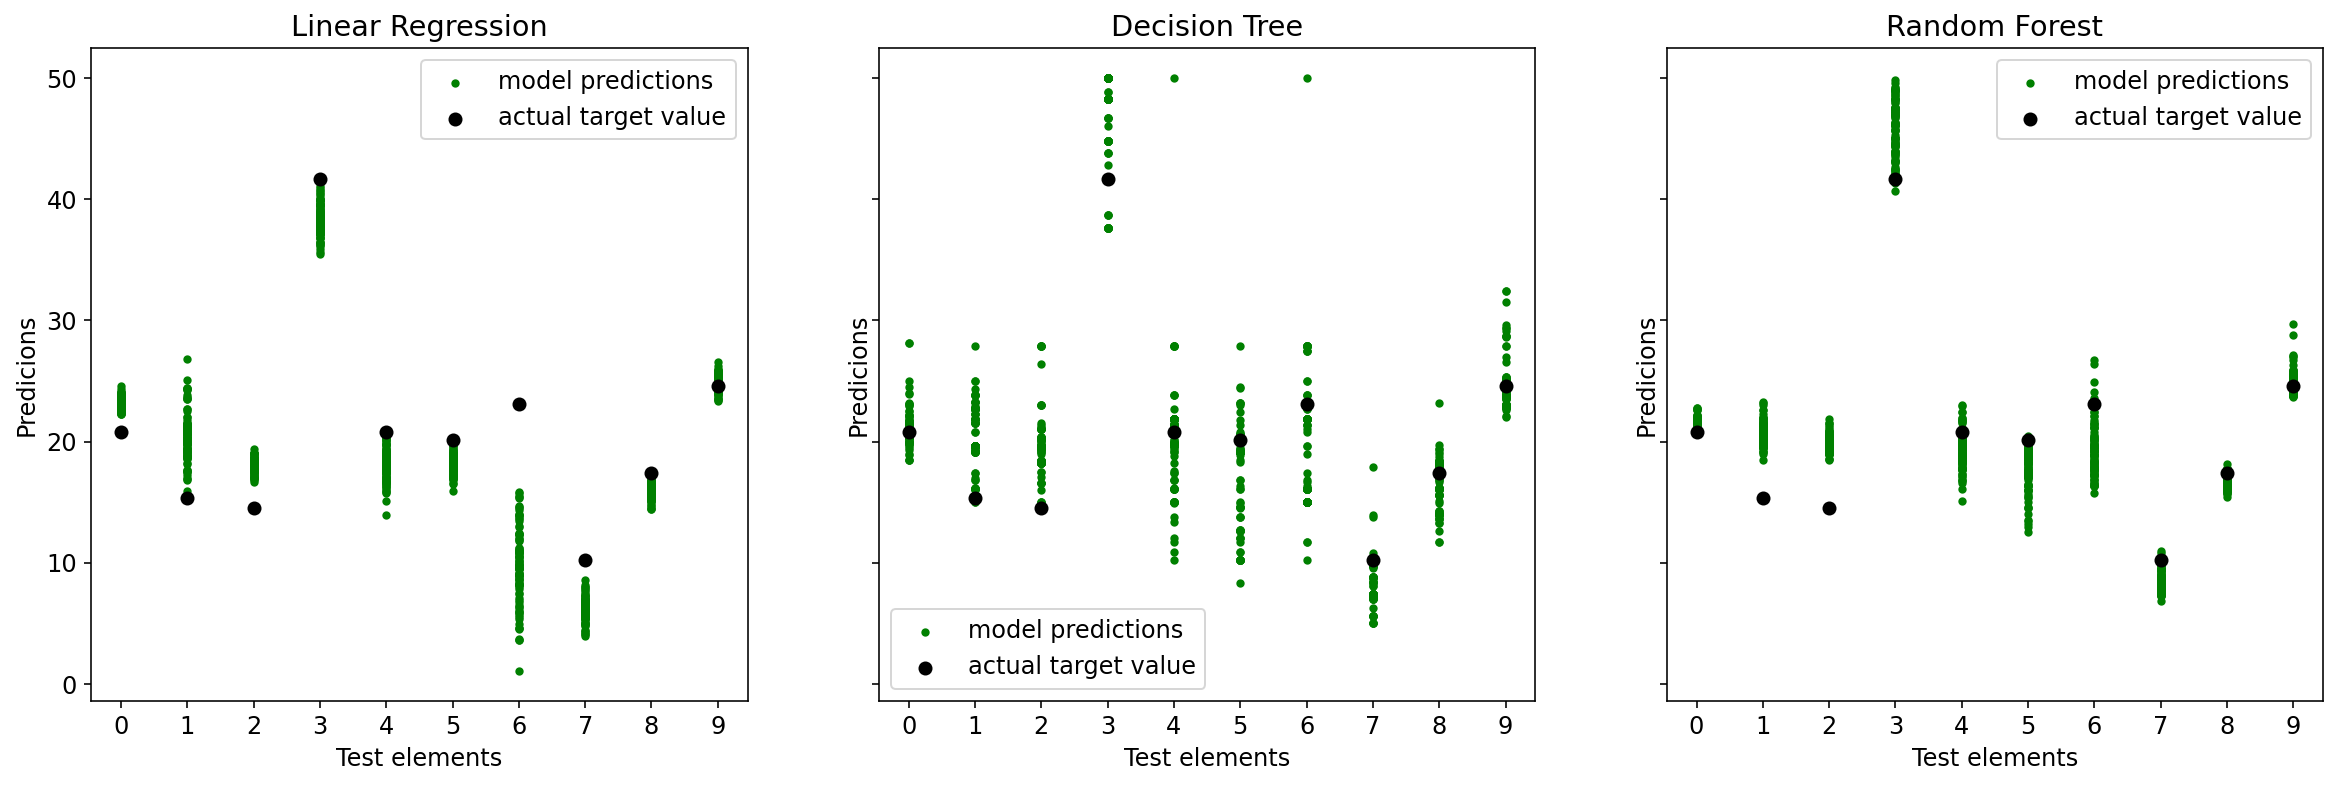

In [17]:
plt.rcParams['figure.figsize'] = 20, 6
plt.rcParams['font.size'] = 12
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
plot_predictions(LinearRegression(), X, y, title='Linear Regression', ax=ax1)
plot_predictions(DecisionTreeRegressor(), X, y, title='Decision Tree', ax=ax2)
plot_predictions(RandomForestRegressor(), X, y, title='Random Forest', ax=ax3)
plt.show()

In [18]:
results

,LR,Tree,RF,BaggingLR,BaggingTree,BaggingRF
Bias,23.73857,10.20214,10.50669,23.74868,10.58522,11.56723
Variance,0.95352,12.87796,2.22285,1.02422,3.42375,1.37660
L_mean,24.69209,23.08010,12.72954,24.77290,14.00897,12.94383
Bias + Variance,24.69209,23.08010,12.72954,24.77290,14.00897,12.94383


__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__
* Как и следовало ожидать, смещение у линейной регрессии очень большое - зачастую черная точка, показывающая ответ на данном объекте, находится даже не близко ко множеству ответов, предсказанных разлисными моделями. Также можно заметить, что зеленые ответы линейной модели лежат достаточно в небольшом диапазоне, то есть разброс низкий.
* У дерева тоже все логично - смещение значительно меньше, а разброс значительно выше. Черная точка уже лучше попадает на зеленые линии, иногда даже примерно в середину, а вот диапазон ответов моделей на каждом объекте уже значительно шире, чем у линейной модели - об этом говорит увеличение длины зеленых линий - то есть разброс большой.
* Что касается случайного леса: видно, что смещение примерно такое же, как и у обычного дерева, а вот разброс уже значительно меньше и скорее напоминает линейную модель, чем дерево. 
* **Вывод**: Графики действительно иллюстрируют результат, полученный ранее и внесенный в таблицу `results`. 

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [19]:
b_depth = []
v_depth = []
for max_depth in range(1, 11):
    b, v, _ = compute_biase_variance(DecisionTreeRegressor(max_depth=max_depth), X, y)
    b_depth.append(b)
    v_depth.append(v)

b_features = []
v_features = []
for max_features in range(1, X.shape[1] + 1):
    b, v, _ = compute_biase_variance(DecisionTreeRegressor(max_features=max_features), X, y)
    b_features.append(b)
    v_features.append(v)

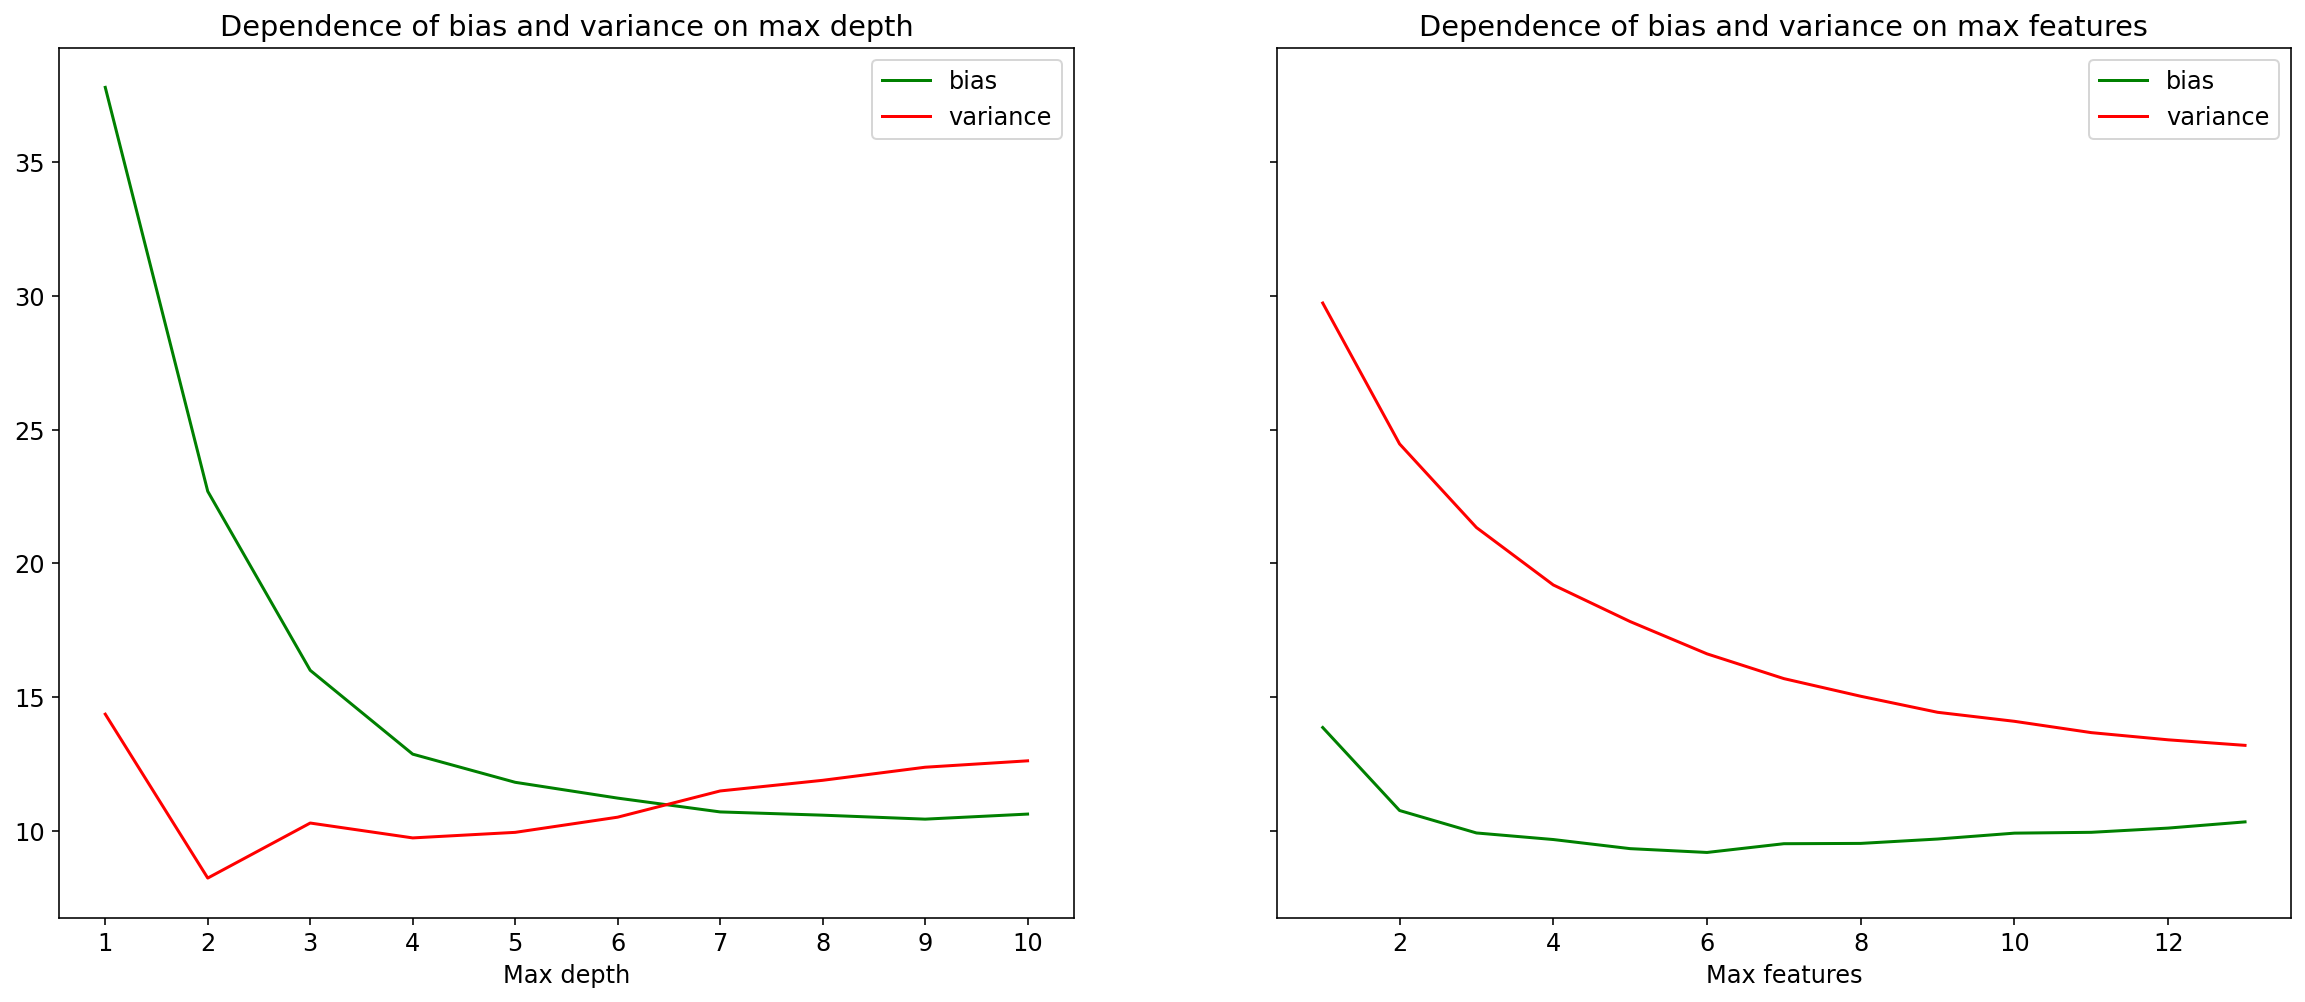

In [20]:
plt.rcParams['figure.figsize'] = 20, 8
plt.rcParams['font.size'] = 12
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.plot(range(1, 11), b_depth, label='bias', c='g')
ax1.plot(range(1, 11), v_depth, label='variance', c='r')
ax1.set_xlabel('Max depth')
ax1.set_xticks(range(1, 11))
ax1.set_title('Dependence of bias and variance on max depth')
ax1.legend()

ax2.plot(range(1, X.shape[1] + 1), b_features, label='bias', c='g')
ax2.plot(range(1, X.shape[1] + 1), v_features, label='variance', c='r')
ax2.set_xlabel('Max features')
ax2.set_title('Dependence of bias and variance on max features')
ax2.legend()
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

In [22]:
b_forest = []
v_forest = []
b_boosting = []
v_boosting = []
for n_estimators in 2**np.arange(1, 10):
    b, v, _ = compute_biase_variance(RandomForestRegressor(n_estimators=n_estimators), X, y)
    b_forest.append(b)
    v_forest.append(v)
    
    b, v, _ = compute_biase_variance(GradientBoostingRegressor(n_estimators=n_estimators), X, y)
    b_boosting.append(b)
    v_boosting.append(v)

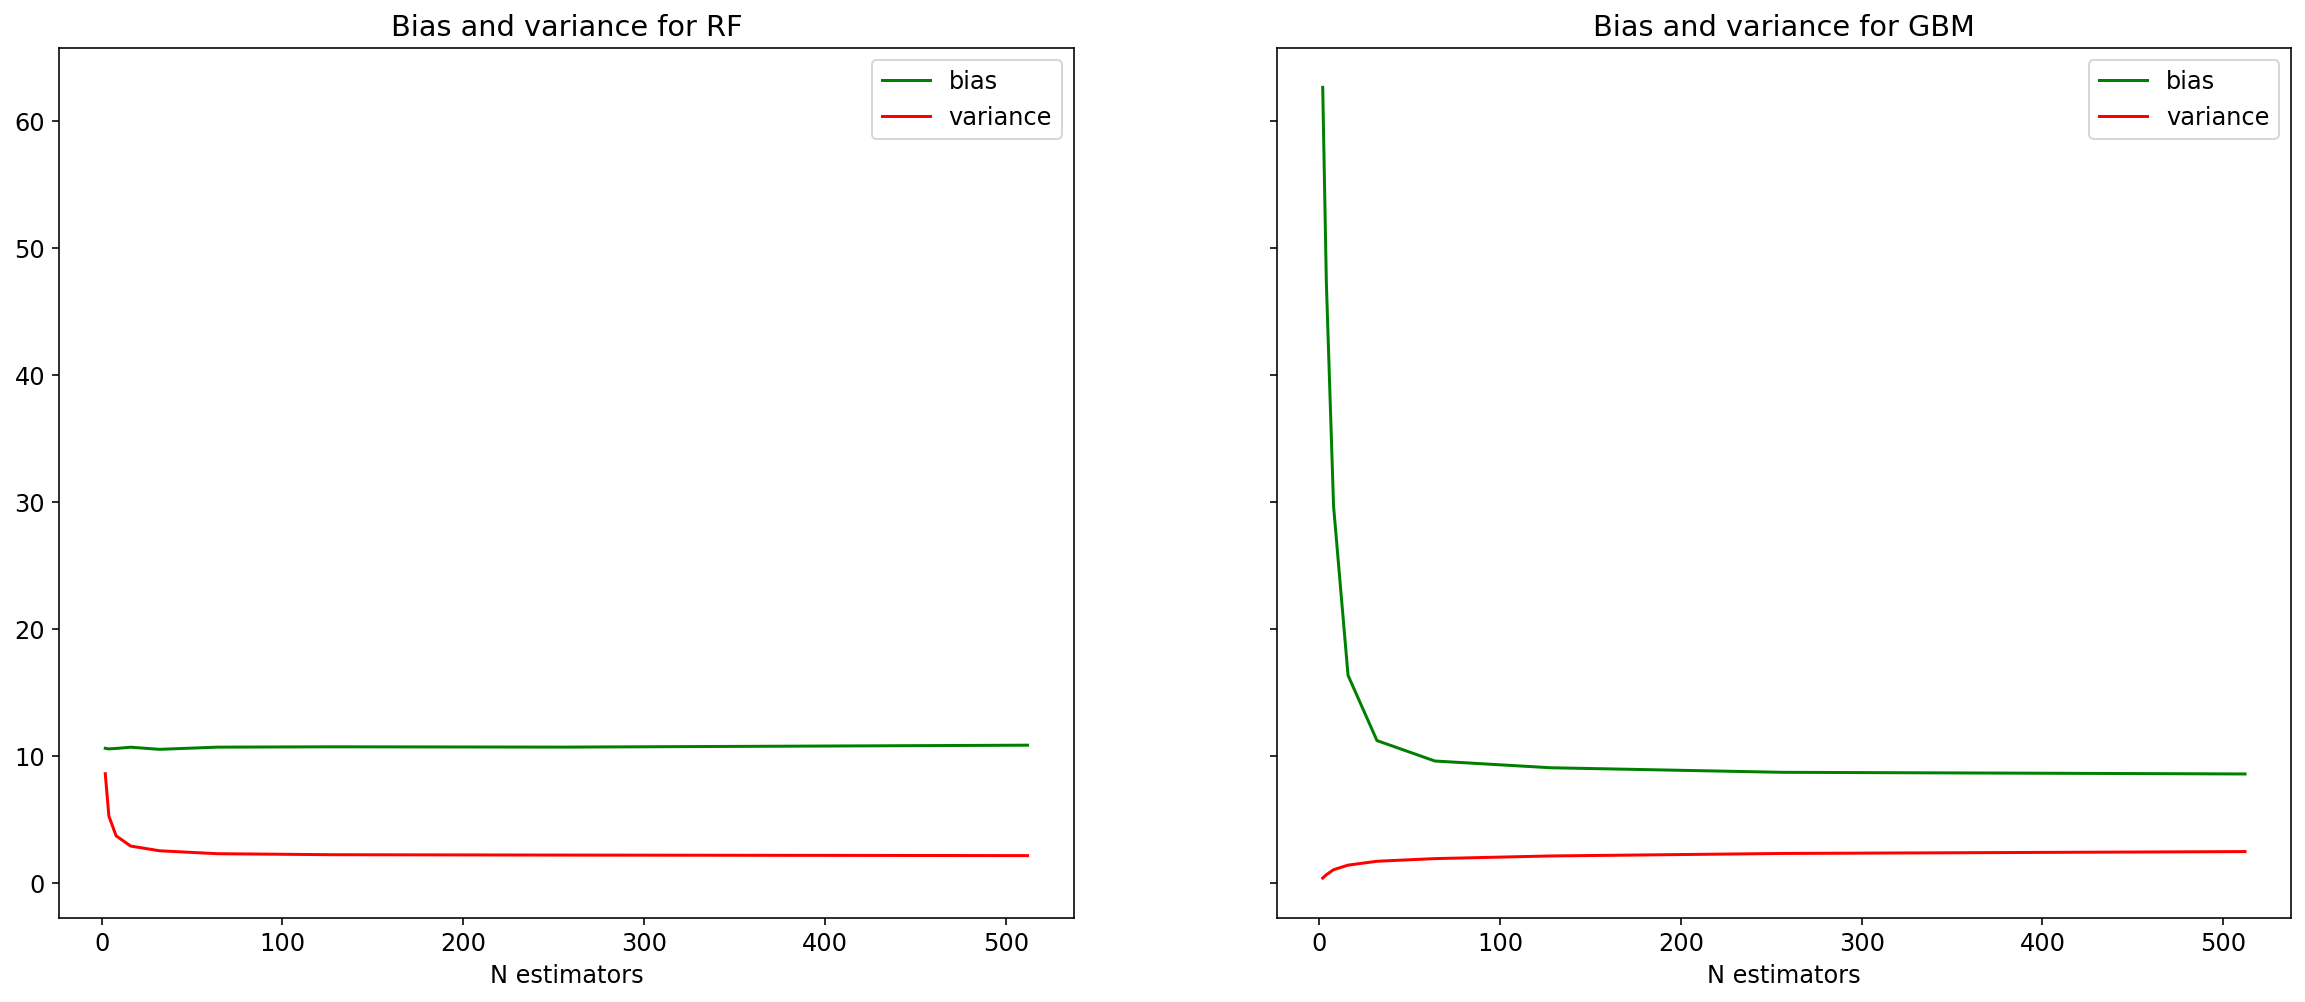

In [23]:
plt.rcParams['figure.figsize'] = 20, 8
plt.rcParams['font.size'] = 12
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.plot(2**np.arange(1, 10), b_forest, label='bias', c='g')
ax1.plot(2**np.arange(1, 10), v_forest, label='variance', c='r')
ax1.set_xlabel('N estimators')
ax1.set_title('Bias and variance for RF')
ax1.legend()

ax2.plot(2**np.arange(1, 10), b_boosting, label='bias', c='g')
ax2.plot(2**np.arange(1, 10), v_boosting, label='variance', c='r')
ax2.set_xlabel('N estimators')
ax2.set_title('Bias and variance for GBM')
ax2.legend()
plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__
* __Решающее дерево и `max_depth`.__ Здесь все понятно - чем глубже дерево, тем мощнее модель и, соответственно, тем ниже смещение. Разброс при этом с увеличением глубины дерева сначала снижался, а потом стал расти. Это объясняется тем, что сначала дерево было недообученным (разброс высокий), потом оно стало адекватным (разброс снизился), а затем дерево стало переобучаться (и разброс стал расти).
* __Решающее дерево и `max_features`.__ Тут тоже все логично - чем больше признаков мы рассматриваем при поиске лучшего предиката, тем менее модель чувствительна к обучающим выборкам и тем ниже разброс. А вот смещение при увеличении гиперпараметра изменялось незначительно и оставалось примерно на одном уровне. Получается, мощность модели практически не зависит от `max_features`.
* __Случайный лес и `n_estimators`.__ Как и обсуждалось на лекциях, случайный лес работает тем лучше, чем больше базовых моделей в него входят, поэтому на графике видно, что смещение +- одинаковое для любого из перебранных значений `n_estimators`, в то время как разброс с ростом гиперпараметра сначала падает, а потом выходит на асимптоту. Падение разброса объясняется тем, что при построении базовых деревьев при выборе каждого предиката признаки берутся из случайного подмножества признаков, вследствие чего корреляция между моделями низкая, и это сильно снижает разброс.
* __Градиентный бустинг и `n_estimators`.__ До значения `n_estimators = 128` смещение в градиентном бустинге падало, после чего оно вышло на асимптоту. Разброс же на данной модели, наоборот - рос до этого значения, после чего уже вышел на асимптоту. Падение смещения можно объяснить тем, что с увеличением числа базовых моделей (которыми в обсновном являются неглубокие деревья) модель все лучше и лучше предсказывает целевую переменную, а значит, становится мощнее. Вообще стоит заметить, что `n_estimators` - это гиперпараметр в градиентном бустинге, и его надо подбирать, тк тут не работает "берем побольше и не паримся", как у случайного леса - с некоторого значения ошибка начинает расти. На данном примере, вероятно использовалось недостаточное количество базовых моделей, чтобы показать данное свойство.

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

![](https://drive.google.com/uc?id=1VUd_pJk1Jt8HHIHLJXGDSKcxyDr5QGiy)